In [1]:
import polars as pl
import matplotlib.pyplot as plt
import psycopg2
from psycopg2.extras import RealDictCursor

DEC2FLOAT = psycopg2.extensions.new_type(
    psycopg2.extensions.DECIMAL.values,
    'DEC2FLOAT',
    lambda value, curs: float(value) if value is not None else None)

psycopg2.extensions.register_type(DEC2FLOAT)

plt.style.use("ggplot")

In [2]:
connection = psycopg2.connect(database="test_crypto_pricing", user="postgres", password="admin", host="localhost", port=5432)

In [3]:
cur = connection.cursor(cursor_factory=RealDictCursor)
cur.execute("select * from market_trade")

db_extract = cur.fetchall()

df = pl.DataFrame(db_extract).sort(by=["ts"])

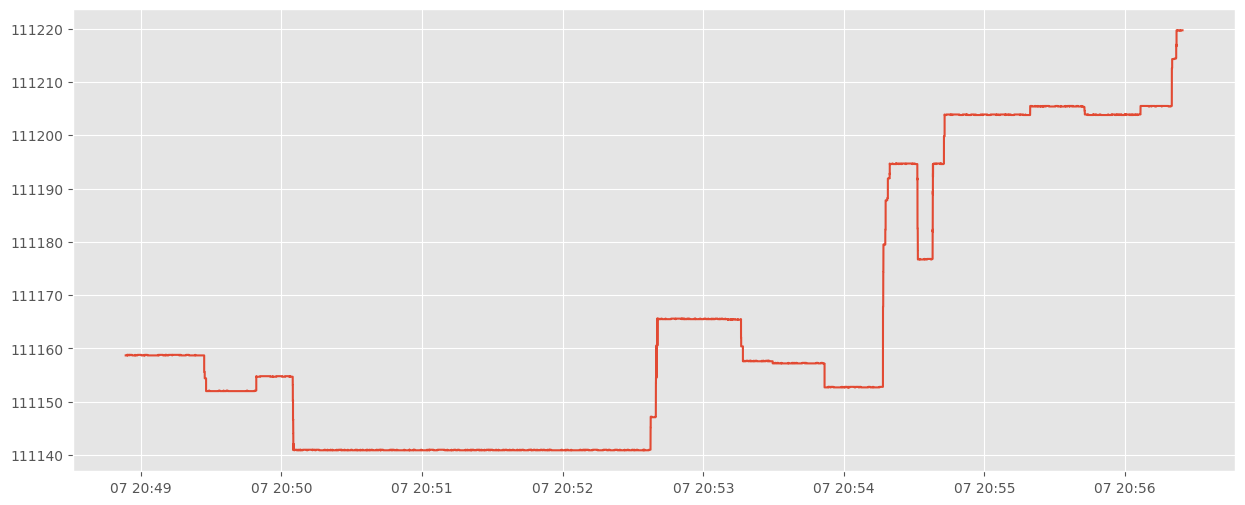

In [4]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.step(df["ts"], df["price"])

In [11]:
q = """
SELECT 
    du.id AS depth_update_id,
    du.symbol,
    du.event_time,
    b.price,
    b.quantity,
    'bid' AS side
FROM depth_updates du
LEFT JOIN bid_depth b ON du.id = b.depth_update_id
WHERE du.id = 1

UNION ALL

SELECT 
    du.id AS depth_update_id,
    du.symbol,
    du.event_time,
    a.price,
    a.quantity,
    'ask' AS side
FROM depth_updates du
LEFT JOIN ask_depth a ON du.id = a.depth_update_id
WHERE du.id = 1

ORDER BY price;  -- or price DESC for bids

"""

In [12]:
cur = connection.cursor(cursor_factory=RealDictCursor)
cur.execute(q)

db_extract = cur.fetchall()

df = pl.DataFrame(db_extract).sort(by=["price"])

In [13]:
df

depth_update_id,symbol,event_time,price,quantity,side
i64,str,"datetime[μs, UTC]",f64,f64,str
1,"""BTCUSDT""",2025-09-07 20:48:53.206 UTC,111157.8,0.006,"""bid"""
1,"""BTCUSDT""",2025-09-07 20:48:53.206 UTC,111157.9,0.002,"""bid"""
1,"""BTCUSDT""",2025-09-07 20:48:53.206 UTC,111158.4,0.002,"""bid"""
1,"""BTCUSDT""",2025-09-07 20:48:53.206 UTC,111158.6,0.004,"""bid"""
1,"""BTCUSDT""",2025-09-07 20:48:53.206 UTC,111158.7,5.419,"""bid"""
1,"""BTCUSDT""",2025-09-07 20:48:53.206 UTC,111158.8,9.925,"""ask"""
1,"""BTCUSDT""",2025-09-07 20:48:53.206 UTC,111158.9,0.046,"""ask"""
1,"""BTCUSDT""",2025-09-07 20:48:53.206 UTC,111159.0,0.073,"""ask"""
1,"""BTCUSDT""",2025-09-07 20:48:53.206 UTC,111159.1,0.006,"""ask"""
